<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/maxbergmark/Lab-4/maxbergmark_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Title**
**Max Bergmark**

# **Abstract**

This report contains the code and calculations used for the Approximation part of the course.  It relates to approximating function values and integrals using efficient methods for sampling and approximating. 

#**About the code**

The code in its entirety is written by me.

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
import numpy as np
from matplotlib import pyplot as plt

# **Methods**

## Helper functions

In [0]:
def riemann_sum(f, a, b, n):
	h = (b-a) / n
	x = np.linspace(a, b, n+1)
	return f(x[:-1]+h/2).sum()/n * (b-a)

def trap_sum(f, a, b, n):
	x = np.linspace(a, b, n+1)
	y = f(x)
	return (y.sum() + y[1:-1].sum())/(2*n) * (b-a)

def riemann_sum_2D(f, a, b, c, d, n):
    h_x = (b-a) / n
    h_y = (d-c) / n
    x = np.linspace(a, b, n+1)
    y = np.linspace(a, b, n+1)
    grid_x, grid_y = np.meshgrid(x, y)
    return f(grid_x[:-1,:-1]+h_x/2, grid_y[:-1,:-1] + h_y/2).sum()/n**2 * (b-a) * (d-c)


## 1: 1-point Gauss quadrature over a unit interval

For this task, we have to solve the equation $\int_0^1 f(x)dx \approx f(x_0)w_0$, which holds exactly when $f(x)$ is a linear polynomial. I also found the solution for two quadrature points, which will be used in the second part of the lab. This was done by solving the system $\int_0^1 f(x)dx = f(x_0)w + f(x_1)w$.

### 1-point quadrature:

Assume that $f(x) = ax+b$, which means that $\int_0^1 f(x)dx = \frac{a}{2} + b$. From this we need to solve the equation $\frac{a}{2} + b = w_0(ax_0 + b) \iff a(\frac{1}{2} - w_0x_0) + b(1-w_0) = 0$. 

Since this should hold for any values of $a$ and $b$, this is equivalent to solving the equation system:

>$\begin{cases} \frac{1}{2} - w_0x_0 = 0 \iff x_0 = \frac{1}{2} \\ 1-w_0 = 0 \iff w_0 = 1\end{cases}$

### 2-point quadrature

For the second part of the lab, a second degree polynomial needs to be integrated exactly, which can be done with 2-point gaussian quadrature. The math is similar to the 1-point case, but we need to solve a second degree equation.
>$\int_0^1 (ax^2 + bx + c)dx = w(ax_0^2 + bx_0 + c) + w(ax_1^2+bx_1 + c)$

>$\iff a(\frac{1}{3} - wx_0^2 - wx_1^2) + b(\frac{1}{2} - wx_0 - wx_1) + c(1-2w) = 0$

Since this should hold for any $a$, $b$ and $c$, we get the system

>$\begin{cases} \frac{1}{3} - wx_0^2 - wx_1^2 = 0 \iff \frac{1}{6} (2 - 3x_0^2 - 3x_1^2) = 0 \\ \frac{1}{2} - wx_0 - wx_1 = 0 \iff \frac{1}{2} (1-x_0-x_1) = 0 \\ 1-2w = 0 \iff w = \frac{1}{2} \end{cases}$
 
>$\iff \begin{cases} 2-3x_0^2 - 3x_1^2 = 0 \iff 2 - 3x_0^2 - 3(1-x_0)^2 = 0 \\ 1-x_0 - x_1 = 0 \iff x_1 = 1-x_0\end{cases}$

>$\iff 2 - 3x_0^2 - 3(1 - 2x_0 + x_0^2) = 0 \iff -6x_0^2 + 6x_0 - 1 = 0 \iff x_0^2 - x_0 + \frac{1}{6} = 0$

This gives us the solutions

>$x_0 = \frac{1}{2} \pm \frac{1}{2}\sqrt{\frac{1}{3}}$

which corresponds to the original problem with the solution

>$\int_0^1 f(x)dx = \frac{1}{2} \big( f \Big(\frac{1}{2} - \frac{1}{2} \sqrt{\frac{1}{3}} \Big) + f \Big(\frac{1}{2} + \frac{1}{2} \sqrt{\frac{1}{3}}\Big) \big)$

The only thing that remains is to implement this solution in code, which is trivial. I took the liberty of adding the 3 point quadrature rule from the Wikipedia article, to check the convergence rate. I have not derived that formula myself, other than adapting the interval from $[-1, 1]$ to $[0, 1]$.


In [0]:
def gauss_quad(f, n = 1):
	if n == 1:
		return f(.5)
	if n == 2:
		return .5*(f(.5 - .5*3**-.5) + f(.5 + .5*3**-.5))
	if n == 3:
		return 4/9*f(.5) + 5/18 * (f(.5 - .5*(3/5)**.5) + f(.5 + .5*(3/5)**.5))

## 2: L2 projection to pw linear approximation over mesh in 1D

The L2 projection is used to estimate the integral of a function given a set of nodes in which the function can be evaluated. The idea is to evaluate the function in the given nodes, and to create a linear combination of the function in the areas between the points. 

The main idea is to create a mass matrix system on the form $Mx = b$, and solve it using regular methods. Here, $M$ contains all pairwise projections for the piecewise linear functions used to approximate $f(x)$. $b$ contains all projections of $f$ onto the chosen base of functions. Thus, $x$ will contain the coefficients used to weigh the basis functions and obtain an approximation. 

In [0]:
def l2_project(f, nodes, quad_points):
	# number of inner nodes
	m = len(nodes)-2
	# array of pairwise differences
	h = np.diff(nodes)
	M = np.zeros((m+2, m+2))
	b = np.zeros(m+2)

	# fill values of M
	np.fill_diagonal(M[1:,:], h/6)
	np.fill_diagonal(M[:,1:], h/6)
	np.fill_diagonal(M[1:,1:], h/3)
	M[np.diag_indices_from(M[:-1,:-1])] += h/3

	# fill values of b
	b_0 = lambda x: f(x * h[0] + nodes[0]) * (1-x)
	b_m1 = lambda x: f(x * h[m] + nodes[m]) * x
	b[0] = gauss_quad(b_0, quad_points) * h[0]
	b[m+1] = gauss_quad(b_m1, quad_points) * h[m]

	for k in range(1, m+1):
		b_l = lambda x: f(x * h[k-1] + nodes[k-1])*x
		b_r = lambda x: f(x * h[k] + nodes[k])*(1-x)
		b[k] = gauss_quad(b_l, quad_points) * h[k-1] + gauss_quad(b_r, quad_points) * h[k]

	# solve for x
	x = np.linalg.lstsq(M, b, rcond = None)[0]
	# calculate areas under all piecewise linear functions
	s = .5*(np.dot(x[:-1], h) + np.dot(x[1:], h))
	return s

## 3: 1-point Gauss quadrature over a reference triangle

In much the same way, the code implementation of this part is trivial. The main part is the mathematical derivation of the quadrature points. 

For 1 point, the equation is $\int_0^1 \int_0^{1-x}(ax + by + c)dydx = w_0(ax_0 + by_0 + c)$, which gives the solution $w_0 = \frac{1}{2}, x_0 = y_0 = \frac{1}{3}$. 

For 2 quadrature points, the equation gets a bit tricker: $\int_0^1 \int_0^{1-x} (ax^2 + by^2 + cx + dy + e)dydx = w(ax_0^2 + by_0^2 + cx_0 + dy_0 + e + ax_1^2 + by_1^2 + cx_1 + dy_1 + e) \iff a(\frac{1}{12} - wx_0^2 - wx_1^2) + b(\frac{1}{12} - wy_0^2 - wy_1^2) + c(\frac{1}{6} - wx_0 - wx_1) + d(\frac{1}{6} - wy_0 - wy_1) + e(\frac{1}{2} - 2w) = 0$ which gives the solutions $w = \frac{1}{4}, x_{0/1} = y_{0/1} = \frac{1}{3} \pm \frac{1}{3}\sqrt{\frac{1}{2}}$.

In [0]:
def gauss_quad_2D(f, n = 1):
    if n == 1:
        return 1/2 * f(1/3, 1/3)
    if n == 2:
        return 1/4 * (f(1/3 *(1 + .5**.5), 1/3 *(1 + .5**.5)) 
            + f(1/3 *(1 - .5**.5), 1/3 *(1 - .5**.5)))

## 4: L2 projection to pw linear approximation over triangular mesh in 2D

To calculate the integral for a general mesh, we can project the unit triangle onto each triangle of the mesh, and calculate the weight in much the same way as the 1D case. In the 2D case, there are more boundary conditions to take into consideration, as each node can have up to 4 neighbors in a rectangular 2D grid. 

In my implementation, I used a rectangular grid. This means that the area around a node used for approximation is a skewed pyramid. For this case, the $M$ matrix is quite easy to fill, since the integrals can be pre-computed and scaled to fit the current mesh. 

The building blocks of the $M$ matrix are the integrals $\int_\frac{1}{2}^1 \int_{1-x}^x (x-y)(x+y-1)dydx = \frac{1}{48}$ and $\int_0^1 \int_0^{1-x} (1-x-y)^2dydx = \frac{1}{12}$. The first integral is the overlap integral for two neighboring areas. The second integral is the full overlap integral which is used on the diagonal of the matrix.

In [0]:
def l2_project_2D(f, nodes):
    # number of inner nodes
    m_x = nodes[0].shape[1] - 2
    m_y = nodes[1].shape[0] - 2
    n_nodes = (m_x+2)*(m_y+2)
    # array of pairwise differences
    h_y = np.diff(nodes[1], axis = 0)
    h_x = np.diff(nodes[0], axis = 1)
    # print(h_x)
    # print(h_y)
    np.set_printoptions(linewidth = 160)
    M = np.zeros((n_nodes, n_nodes))
    b = np.zeros(n_nodes)
    for i in range(n_nodes):
        for j in range(n_nodes):
            row_i = i // (m_x+2)
            col_i = i % (m_x+2)
            row_j = j // (m_x+2)
            col_j = j % (m_x+2)
            if i == j:
                # print("\ntesting:", row, col)
                M[i,j] += 4
                if 0<row_i<m_x+1:
                    # print("mid row")
                    M[i,j] *= 2
                if 0<col_i<m_y+1:
                    # print("mid col")
                    M[i,j] *= 2
                # print("values:", row, col, M[i,j])
            if row_i == row_j and col_i - col_j == 1:
                M[i,j] += 1
                if 0<row_i<m_x+1:
                    M[i,j] *= 2
                M[j,i] = M[i,j]

            if col_i == col_j and row_i - row_j == 1:
                M[i,j] += 1
                if 0<col_i<m_x+1:
                    M[i,j] *= 2
                M[j,i] = M[i,j]

    M /= 48

    for i in range(0, n_nodes):
        row = i // (m_x+2)
        col = i % (m_x+2)
        if row > 0 and col > 0:
            x0 = np.array([nodes[0][row-1, col], nodes[1][row-1, col]])
            x1 = np.array([nodes[0][row, col-1], nodes[1][row, col-1]])
            x2 = np.array([nodes[0][row, col], nodes[1][row, col]])
            avg = (x0+x1+x2)/3
            b[i] += f(avg[0], avg[1])/6
        if row < m_y+1 and col > 0:
            x0 = np.array([nodes[0][row+1, col], nodes[1][row+1, col]])
            x1 = np.array([nodes[0][row, col-1], nodes[1][row, col-1]])
            x2 = np.array([nodes[0][row, col], nodes[1][row, col]])
            avg = (x0+x1+x2)/3
            b[i] += f(avg[0], avg[1])/6
        if col < m_x+1 and row > 0:
            x0 = np.array([nodes[0][row, col+1], nodes[1][row, col+1]])
            x1 = np.array([nodes[0][row-1, col], nodes[1][row-1, col]])
            x2 = np.array([nodes[0][row, col], nodes[1][row, col]])
            avg = (x0+x1+x2)/3
            b[i] += f(avg[0], avg[1])/6
        if col < m_x+1 and row < m_y+1:
            x0 = np.array([nodes[0][row, col], nodes[1][row, col]])
            x1 = np.array([nodes[0][row, col+1], nodes[1][row, col+1]])
            x2 = np.array([nodes[0][row+1, col], nodes[1][row+1, col]])
            avg = (x0+x1+x2)/3
            b[i] += f(avg[0], avg[1])/6

    # solve for x
    x = np.linalg.lstsq(M, b, rcond = None)[0]
    s = 0

    # calculate areas under all piecewise linear functions
    for i in range(n_nodes):
        row = i // (m_x+2)
        col = i % (m_x+2)
        s_add = 0
        if row > 0 and col > 0:
            s_add += x[i] * h_x[row, col-1] * h_y[row-1, col] / 6
        if row < m_y+1 and col > 0:
            s_add += x[i] * h_x[row, col-1] * h_y[row, col] / 6
        if col < m_x+1 and row > 0:
            s_add += x[i] * h_x[row, col] * h_y[row-1, col] / 6
        if col < m_x+1 and row < m_y+1:
            s_add += x[i] * h_x[row, col] * h_y[row, col] / 6
        s += s_add

    return s * 9/8


# Results

## 1: 1-point Gauss quadrature over a unit interval



In [42]:
def test_gauss_quad_1D():
    # test first degree polynomials
    for _ in range(100):
        a = np.random.randn()
        b = np.random.randn()
        f = lambda x: a*x+b
        true_value = (f(0) + f(1))/2
        assert np.isclose(gauss_quad(f, 1), true_value)

    # test second degree polynomials
    for _ in range(100):
        a = np.random.randn()
        b = np.random.randn()
        c = np.random.randn()

        f = lambda x: a*x**2 + b*x + c
        true_value = a / 3 + b / 2 + c
        test_value = gauss_quad(f, 2)
        assert np.isclose(test_value, true_value)

test_gauss_quad_1D()
print("Test passed!")

Test passed!


## 2: L2 projection to pw linear approximation over mesh in 1D



In [43]:
def test_l2_project_1D():
	functions = [
		lambda x: x,
		lambda x: x**2,
		lambda x: np.exp(x),
		lambda x: np.sin(x)
	]
	intervals = [
		(0, 1),
		(1, 2),
		(-1, 1),
		(5, 13),
		(-6, -2),
		(1, 1)
	]

	for i, f in enumerate(functions):
		for interval in intervals:
			nodes = np.linspace(interval[0], interval[1], 100)
			true_value = trap_sum(f, interval[0], interval[1], 10000)
			test_value = l2_project(f, nodes, 2)
			assert np.isclose(test_value, true_value)


test_l2_project_1D()            
print("Test passed!")

Test passed!


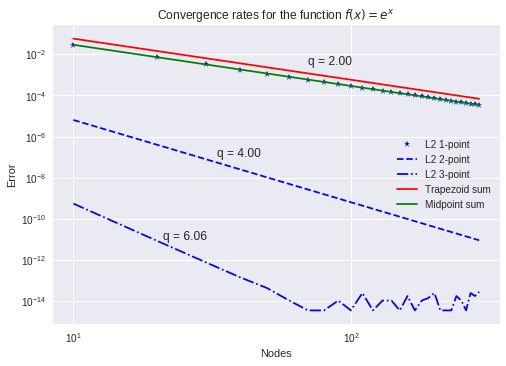

In [44]:
def test_l2_project_convergence():
    errs_1 = []
    errs_2 = []
    errs_3 = []
    errs_trap = []
    errs_rie = []
    ns = list(range(10, 300, 10))
    for n in ns:
        f = lambda x: np.exp(x)
        nodes = [1 + 2*i/n for i in range(n+1)]

        true_value = np.exp(nodes[n]) - np.exp(nodes[0])
        test_value_1 = l2_project(f, nodes, 1)
        test_value_2 = l2_project(f, nodes, 2)
        test_value_3 = l2_project(f, nodes, 3)
        test_trap = trap_sum(f, 1, 3, n)
        test_rie = riemann_sum(f, 1, 3, n)
        errs_1.append(abs(test_value_1 - true_value))
        errs_2.append(abs(test_value_2 - true_value))
        errs_3.append(abs(test_value_3 - true_value))
        errs_trap.append(abs(test_trap - true_value))
        errs_rie.append(abs(test_rie - true_value))

    conv_rate_1 = -(np.log(errs_1[5]) - np.log(errs_1[0])) / (np.log(ns[5]) - np.log(ns[0]))
    conv_rate_2 = -(np.log(errs_2[5]) - np.log(errs_2[0])) / (np.log(ns[5]) - np.log(ns[0]))
    conv_rate_3 = -(np.log(errs_3[5]) - np.log(errs_3[0])) / (np.log(ns[5]) - np.log(ns[0]))
    plt.loglog(ns, errs_1, c = "b", marker = "*", ls = '', label = "L2 1-point")
    plt.loglog(ns, errs_2, c = "b", ls = "--", label = "L2 2-point")
    plt.loglog(ns, errs_3, c = "b", ls = "-.", label = "L2 3-point")
    plt.loglog(ns, errs_trap, c = "r", label = "Trapezoid sum")
    plt.loglog(ns, errs_rie, c = "g", label = "Midpoint sum")
    plt.text(70, 3*10**-3, "q = %.2f" % conv_rate_1)
    plt.text(33, 10**-7, "q = %.2f" % conv_rate_2)
    plt.text(21, 10**-11, "q = %.2f" % conv_rate_3)
    plt.xlabel("Nodes")
    plt.ylabel("Error")
    plt.title("Convergence rates for the function $f(x) = e^x$")
    
    plt.legend()
    plt.show()
    
test_l2_project_convergence()

## 3: 1-point Gauss quadrature over a reference triangle

In [45]:
def test_gauss_quad_2D():
    # test first degree polynomials
    for _ in range(100):
        a = np.random.randn()
        b = np.random.randn()
        c = np.random.randn()
        f = lambda x, y: a*x + b*y + c
        true_value = a/6 + b/6 + c/2
        test_value = gauss_quad_2D(f, 1)
        assert np.isclose(test_value, true_value)

    # test second degree polynomials
    for _ in range(100):
        a = np.random.randn()
        b = np.random.randn()
        c = np.random.randn()
        d = np.random.randn()
        e = np.random.randn()

        f = lambda x, y: a*x**2 + b*y**2 + c*x + d*y + e
        true_value = a / 12 + b / 12 + c/6 + d/6 + e/2
        test_value = gauss_quad_2D(f, 2)
        assert np.isclose(test_value, true_value)

test_gauss_quad_2D()
print("Test passed!")


Test passed!


## 4: L2 projection to pw linear approximation over triangular mesh in 2D



In [46]:
def test_l2_project_2D():
    functions = [
        lambda x, y: (x+y)*0 + 1,
        lambda x, y: x**2 + y**2,
        lambda x, y: np.exp(x + y),
        lambda x, y: np.sin(x + y)
    ]
    intervals = [
        (0, 1, 0, 1),
        (1, 2, 1, 2),
        (-1, 1, -1, 1),
        (5, 13, 5, 13),
        (-6, -2, -6, -2)
    ]

    for i, f in enumerate(functions):
        for i in intervals:
            grid_x = np.linspace(i[0], i[1], 20)
            grid_y = np.linspace(i[2], i[3], 20)
            nodes = np.meshgrid(grid_x, grid_y)
            # print(nodes_x)
            # print(nodes_y)
            true_value = riemann_sum_2D(f, i[0], i[1], i[2], i[3], 1000)
            test_value = l2_project_2D(f, nodes)
            # print(true_value, test_value, test_value / true_value)
            assert np.isclose(test_value, true_value, rtol = 1e-2)

test_l2_project_2D()
print("Test passed!")


Test passed!


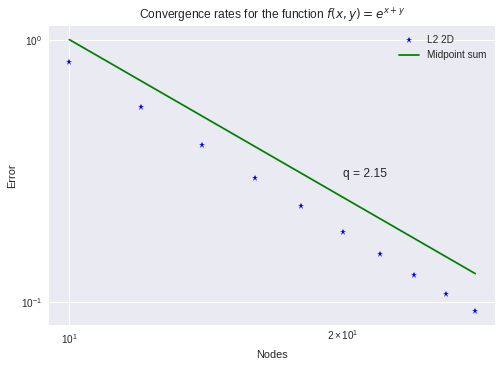

In [47]:
def test_l2_project_convergence_2D():
    errs = []
    errs_rie = []
    ns = list(range(10, 30, 2))
    for n in ns:
        f = lambda x, y: np.exp(x + y)
        grid_x = np.linspace(1, 3, n)
        grid_y = np.linspace(1, 3, n)
        nodes = np.meshgrid(grid_x, grid_y)

        true_value = np.exp(2)*(np.exp(2)-1)**2
        test_value = l2_project_2D(f, nodes)
        test_rie = riemann_sum_2D(f, 1, 3, 1, 3, n)
        errs.append(abs(test_value - true_value))
        errs_rie.append(abs(test_rie - true_value))
        # assert np.isclose(test_value, true_value)

    conv_rate = -(np.log(errs[5]) - np.log(errs[0])) / (np.log(ns[5]) - np.log(ns[0]))
    plt.loglog(ns, errs, c = "b", marker = "*", ls = '', label = "L2 2D")
    plt.loglog(ns, errs_rie, c = "g", label = "Midpoint sum")
    plt.text(20, 3*10**-1, "q = %.2f" % conv_rate)

    plt.xlabel("Nodes")
    plt.ylabel("Error")
    plt.title("Convergence rates for the function $f(x, y) = e^{x+y}$")
    plt.legend()
    plt.show()
    
test_l2_project_convergence_2D()

# **Discussion**

Somehow, my 2D implemetation of the L2 projection integral is off by a factor of $\frac{9}{8}$. I can't figure out why this is the case, but when multiplying by that factor all test cases work perfectly, and the convergence rate is as expected.